# Modelo

El objetivo de este notebook es definir el proceso de entrenamiento de los dos modelos: U-Net y DeepLabV3+. En esta tarea vamos a emplear los datos sobre la depuración de imagenes que realizamos en el notebook *visual-prev*

## Librerias

A continuación se importan las librerias requeridas para el desarrollo de este notebook

In [1]:
from sklearn.preprocessing import MinMaxScaler

from matplotlib import colors
from skimage import exposure
from tqdm.notebook import tqdm

# =================|
# Tensorflow
# =================

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, MaxPool2D, UpSampling2D, Concatenate
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import Sequence

from scipy import ndimage

#=========================

import rasterio as rio
import rasterio.plot as rio_plot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import json
import typing as typ
import math
import time

# Semilla pseudoaleatoria
np.random.seed(24)

# Tamaño de las figuras
plt.rcParams["figure.figsize"] = (20,10)

# Ruta base de la carpeta de datos
DATA_BASE = "/home/ggonzr_cloud/deeplearn/data"

# Imagen
HEIGHT = 256
WIDTH = 256
CHANNELS = 4

La siguiente celda nos ayudara a limpiar el grafo de ejecución de Tensorflow

In [2]:
tf.keras.backend.clear_session()

## Definición del modelo

En este apartado vamos a definir los modelos que vamos a utilizar empleando el API de alto nivel de Keras. De igual modo, se referencian algunas implementaciones de los modelos en Tensorflow para cada una de las arquitecturas.

### U-Net

Implementación realizada por Nikhil Tomar en el proyecto Multiclass Segmentation in U-Net (2020). Disponible en: https://github.com/nikhilroxtomar/Multiclass-Segmentation-in-Unet/blob/master/model.py

In [3]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

### DeepLab V3+

Implementación recuperada de la documentación de la libreria Keras. Esta implementación fue realizada por Soumik Rakshit (2021) y se encuentra disponible en: https://keras.io/examples/vision/deeplabv3_plus/

In [4]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [5]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

## Funciones de carga de datos

A continuación encontrará la definición de algunas funciones auxiliares para la carga y procesamiento de los datos

La siguiente función la utilizamos cuando queremos cargar los datos directamente en memoria. Su objetivo es retornar un arreglo de numpy inicializado en ceros con las dimensiones [# imagenes, alto, ancho, canales]

In [6]:
def create_img_array(num_img, heigth, width, channels: int = 1) -> typ.Tuple[np.array, np.array]:
    array_rsp = np.zeros((num_img, heigth, width, channels), dtype=np.float32)    
    return array_rsp

Esta función permite cargar un determinado canal de un raster. Por defecto, cada imagen satelital está representada por una carpeta y en su interior hay un archivo por cada banda del espectro electromagnetico

In [7]:
def load_channel_raster(path_raster_tiff: str, channel: int = 1, shape=(HEIGHT, WIDTH)) -> np.array:
    try:
        rsp = None
        with rio.open(path_raster_tiff, "r") as rf:
            rsp = rf.read(channel)
        return rsp 
    except:
        print(f"Error de carga - Raster {path_raster_tiff}")
        new_shape = (channel, shape[0], shape[1])
        return np.zeros(new_shape)

La siguiente función carga todas las bandas de una imagen satelital Sentinel-2 (12), recibe por entrada la ruta de la carpeta de la imagen y retorna un arreglo de las siguientes dimensiones [banda, alto, ancho]

In [8]:
def load_source_img(img_folder_path: str) -> np.array:
    # Obtener la referencia a las bandas
    # Un poco excesivo, pero por si las moscas, especificaremos el patron de cada imagen a mano
    aerosol_1 = glob.glob(f"{img_folder_path}/B01.*")[0]
    azul_2 = glob.glob(f"{img_folder_path}/B02.*")[0]
    verde_3 = glob.glob(f"{img_folder_path}/B03.*")[0]
    rojo_4 = glob.glob(f"{img_folder_path}/B04.*")[0]
    rojo_frontera_1_5 = glob.glob(f"{img_folder_path}/B05.*")[0]
    rojo_frontera_2_6 = glob.glob(f"{img_folder_path}/B06.*")[0]
    rojo_frontera_3_7 = glob.glob(f"{img_folder_path}/B07.*")[0]
    infrarrojo_8 = glob.glob(f"{img_folder_path}/B08.*")[0]
    infrarrojo_8A_9 = glob.glob(f"{img_folder_path}/B8A.*")[0]
    vapor_agua_9_10 = glob.glob(f"{img_folder_path}/B09.*")[0]
    onda_corta_1_11 = glob.glob(f"{img_folder_path}/B11.*")[0]
    onda_corta_2_12 = glob.glob(f"{img_folder_path}/B12.*")[0]
    
    # Cargar las cuatro bandas
    channels_list = [
        aerosol_1,
        azul_2,
        verde_3,
        rojo_4,
        rojo_frontera_1_5,
        rojo_frontera_2_6,
        rojo_frontera_3_7,
        infrarrojo_8,
        infrarrojo_8A_9,
        vapor_agua_9_10,
        onda_corta_1_11,
        onda_corta_2_12
    ]
    
    raster_bands = [
        load_channel_raster(r)
        for r in channels_list
    ]
    
    # Evitar los NaN, +Infinite, -Infinite
    raster_bands_clean = [
        np.nan_to_num(r, nan=0, posinf=0, neginf=0)
        for r in raster_bands
    ]
    
    # Normalizar los canales
    norm_data = lambda x: ((x - np.mean(x))/ np.std(x))
                           
    # Aplicar
    norm_raster_bands = [
        norm_data(raster_band)
        for raster_band in raster_bands_clean
    ]
            
    # Construir el arreglo y retornar
    return np.array(norm_raster_bands)

La siguiente función carga la máscara de una imagen satelital. Sus dimensiones son [alto, ancho] y cada pixel representa la etiqueta de clase con un número entre 1 y 7

In [9]:
def load_mask_img(mask_folder_path: str) -> np.array:
    # Obtener la referencia de la máscara
    mask_path = glob.glob(f"{mask_folder_path}/labels.*")[0]
    
    # Retornar la máscara
    loaded_channel = load_channel_raster(mask_path)
    loaded_channel_clean = np.nan_to_num(loaded_channel, nan=0, posinf=0, neginf=0)
    
    return loaded_channel_clean

La siguiente función toma una imagen satelital representada en un arreglo con todas sus bandas y calcula el indice espectral NDVI

In [10]:
def ndvi(raster_array: np.array) -> np.array:    
    # Las dimensiones aca son [bandas, altura, ancho]
    # Formula: NDVI (Sentinel 2) = (B8 – B4) / (B8 + B4)
    # Se toma con base en la modificacion con 12 bandas    
    # Mayor informacion, por favor ver definicion del metodo: load_source_img
    red_channel = raster_array[3, :, :]
    infrared_channel = raster_array[7, :, :]
    
    # Evitar divisiones por cero e inestabilidades
    epsilon = 1e-8
    return ((infrared_channel - red_channel) / ((infrared_channel + red_channel) + epsilon))

La siguiente función toma una imagen satelital representada en un arreglo con todas sus bandas y calcula el indice espectral BSI (Bare Soil Index)

In [11]:
def bsi(raster_array: np.array) -> np.array:    
    # Las dimensiones aca son [bandas, altura, ancho]    
    # Se toma con base en la modificacion con 12 bandas    
    # Mayor informacion, por favor ver definicion del metodo: load_source_img
    # BSI (Sentinel 2) = (B11 + B4) – (B8 + B2) / (B11 + B4) + (B8 + B2)
    
    swir_1_11 = raster_array[10, :, :]
    rojo_4 = raster_array[3, :, :]
    infrarrojo_8 = raster_array[7, :, :]
    azul_2 = raster_array[1, :, :]
    
    # Evitar divisiones por cero e inestabilidades
    epsilon = 1e-8
    
    # SWIR <-> ROJO
    swir_rojo = swir_1_11 + rojo_4
    # NIR <-> AZUL
    nir_azul = infrarrojo_8 + azul_2
    
    # Retornar
    return (swir_rojo - nir_azul) / (swir_rojo + nir_azul + epsilon)

La siguiente función toma una imagen satelital representada en un arreglo con todas sus bandas y calcula el indice espectral NDMI

In [12]:
def ndmi(raster_array: np.array) -> np.array:    
    # Las dimensiones aca son [bandas, altura, ancho]    
    # Se toma con base en la modificacion con 12 bandas    
    # Mayor informacion, por favor ver definicion del metodo: load_source_img
    # NDMI (Sentinel 2) = (B8 – B11) / (B8 + B11)
    swir_1_11 = raster_array[10, :, :]
    infrarrojo_8 = raster_array[7, :, :]
    
    # Evitar divisiones por cero e inestabilidades
    epsilon = 1e-8
    
    return (infrarrojo_8 - swir_1_11) / (infrarrojo_8 + swir_1_11)

La siguiente función se encarga de retornar la ruta de la carpeta de acceso de la máscara con base en su ID de región (chip_id)

In [13]:
def get_label_mask_path_folder(chip_id: str) -> str:
    # Retorna la ruta con base en el chip
    label_folder = f"{DATA_BASE}/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_{chip_id}"
    return label_folder

La siguiente función se encarga de transformar la máscara cargada a partir del raster y generar una codificación One Hot por cada clase que queramos identificar. En total tendriamos 7 clases y las dimensiones resultantes son [clase, alto, ancho] donde cada pixel toma el valor cero o uno si pertenece a una determinada clase

In [14]:
def label_mask_one_hot(raster_mask: np.array, classes: typ.List[int]) -> np.array:
    # Retorna una máscara One Hot por cada clase
    # Obtenerla en 2D solo con el primer canal
    raster_mask_2d = raster_mask 
    masks = [
        (raster_mask_2d == i).astype(np.uint16)
        for i in classes
    ]
    
    return np.array(masks)

## Secuenciadores

A continuación definimos un secuenciador. Este elemento es muy importante para la carga y procesamiento en segundo plano de lotes de datos y permite entrenar el modelo sin la necesidad de cargar todos los datos en memoria

In [15]:
class IndexSequence(Sequence):
    # x_sample_path: Arreglo con el contenido de las rutas e ID
    # Administra los batch de trabajo.    
    def __init__(self, x_sample_path: np.array, batch_size: int = 32):
        self.x_sample_path = x_sample_path
        self.batch_size = batch_size
        self.classes = list(range(1,8))
    
    
    def __len__(self):
        return math.ceil(self.x_sample_path.shape[0] / self.batch_size)
    
    
    def load_img_index(self, source_path):
        # Cargar el raster inicial -> [canal, alto, ancho]
        source_raster = load_source_img(source_path)
        
        # Transformar la imagen
        ndvi_transformed = ndvi(source_raster)
        bsi_transformed = bsi(source_raster)
        ndmi_transformed = ndmi(source_raster)        
        
        # Empaquetar y retornar
        index_array = np.array([
            ndvi_transformed,
            bsi_transformed,
            ndmi_transformed
        ])
        
        return rio_plot.reshape_as_image(index_array)
    
    
    def load_img_mask(self, chip_id):
        # Cargar la máscara inicial -> [clase, alto, ancho]
        mask_folder_path = get_label_mask_path_folder(chip_id=chip_id)
        mask_raster = load_mask_img(mask_folder_path)
        
        # Sobre las clases
        mask_raster_classes = label_mask_one_hot(mask_raster, self.classes)        
        
        return rio_plot.reshape_as_image(mask_raster_classes)
                

    def __getitem__(self, idx):
        # Obtener el batch de datos para cargar
        batch_x = self.x_sample_path[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        
        # Arreglo de datos para imagenes
        source_images = np.array([
            self.load_img_index(row_data[2])
            for row_data in batch_x
        ])
        
        # Arreglo de datos con las máscaras
        mask_images = np.array([
            self.load_img_mask(row_data[1])
            for row_data in batch_x
        ])

        return source_images, mask_images

## Cargar los datos de las imagenes 

A continuación vamos a leer el conjunto de datos con las imagenes filtradas y vamos a generar una muestra para entrenar los modelos. 

In [16]:
# Cargar JSON con las imagenes
images_df = pd.read_json(f"{DATA_BASE}/images_to_use.json")

In [17]:
# Determinar muestra
SAMPLE_SIZE = 0.05
sample_train = images_df.sample(frac=SAMPLE_SIZE, random_state=24)
sample_train_np = sample_train.to_numpy()

In [18]:
samples_number = sample_train_np.shape[0]
print(f"Muestras: {samples_number}")

Muestras: 1509


### Carga completa de las bandas

En el siguiente apartado se detalla el proceso de carga de las imágenes si se desea cargar los datos en memoria. Se deja esta sección solo como ilustración debido a que en el entrenamiento del modelo no se puede emplear esta aproximación debido al gran volumen de datos a procesar

In [16]:
# Construir el arreglo
X = create_img_array (
    num_img = samples_number,
    heigth = HEIGHT,
    width = WIDTH,
    channels = 12
)

Y = create_img_array (
    num_img = samples_number,
    heigth = HEIGHT,
    width = WIDTH,  
    channels = 7
)

In [17]:
# Ejecutar la carga
for row_id in tqdm(range(len(sample_train_np))):
    row = sample_train_np[row_id]
    chip_id = row[1]
    source_path = row[2]
    
    # Cargar la imagen fuente
    source_raster = load_source_img(source_path)
    
    # Transformar con NDVI
    # Descartar para la version V2 de U-Net
    #source_raster = ndvi(source_raster)
    
    # Cargar la máscara
    mask_folder_path = get_label_mask_path_folder(chip_id=chip_id)
    mask_raster = load_mask_img(mask_folder_path)
    mask_raster_classes = label_mask_one_hot(mask_raster, list(range(1,8)))
    
    # A este punto tenemos dimensiones
    # Fuente (source) -> [canal, alto, ancho] -> [12, 256, 256]
    # Máscara -> [clase, alto, ancho] -> [7, 256, 256]
    
    # Aplicar transformaciones si son necesarias
    # Cambian el orden de las dimensiones
    # [alto, ancho, canal/clase] -> Por ejemplo: [256, 256, 12]
    
    # Almacenar    
    X[row_id] = rio_plot.reshape_as_image(source_raster)
    Y[row_id] = rio_plot.reshape_as_image(mask_raster_classes)
    break

  0%|          | 0/30178 [00:00<?, ?it/s]

## Conjuntos de entrenamiento, validación, test

A continuación se define la creación de los conjuntos de entrenamiento, validación y test que se van a emplear para el desarrollo del modelo

### Por medio de arreglos

Para la distribución del conjunto de datos por esta aproximación es necesario que se hayan cargado los datos en memoria previamente

In [17]:
# Distribuir el conjunto de entrenamiento en dos, train y test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Distribuir el conjunto de entrenamiento en dos, train y valid (validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Por medio de secuenciadores

Debido a que los secuenciadores realizan el proceso de carga en tiempo de ejecución, su entrada será la ruta de la carpeta de las imágenes satelitales y sus máscaras en el sistema de archivos. Por ello, vamos a dividir el conjunto de rutas de acceso de carpetas en este apartado

In [19]:
# Distribuir la ruta de las imagenes en los conjuntos apropiados
X_seq_train, X_seq_test = train_test_split(sample_train_np, test_size=0.2, random_state=42)
# Validacion
X_seq_train, X_seq_val = train_test_split(X_seq_train, test_size=0.2, random_state=42)

Para procesamiento futuros, vamos a guardar en un DataFrame y posteriormente en un archivo **JSON** los identificadores de las imágenes del conjunto de test

In [23]:
# Guardar el conjunto de test
test_df = pd.DataFrame(X_seq_test)
test_df.columns = sample_train.columns
test_df

,image_id,chip_id,image_folder_path,cloud_mask_mean
0,33PWQ_13_20180504,33PWQ_13,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
1,35NRD_15_20180113,35NRD_15,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
2,31PGR_26_20181117,31PGR_26,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
3,34LHJ_20_20180620,34LHJ_20,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
4,32PPA_20_20180410,32PPA_20,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
...,...,...,...,...
1504,34NBP_29_20180513,34NBP_29,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000122
1505,33KXV_05_20180924,33KXV_05,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
1506,34JBL_26_20180817,34JBL_26,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
1507,36PZC_22_20180405,36PZC_22,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0


Almacenar el contenido en un archivo **JSON**

In [24]:
# Almacenar
test_df.to_json(f"{DATA_BASE}/test_set.json")

Instanciar los secuenciadores con la ruta de las imágenes satelitales

In [20]:
# Instanciar los secuenciadores: En este caso vamos a trabajar con indices
train_index_seq = IndexSequence(x_sample_path=X_seq_train)
val_index_seq = IndexSequence(x_sample_path=X_seq_val)

## Instanciar el modelo

En este apartado vamos a instanciar, compilar y entrenar cada uno de los modelos

### U-Net

En primer lugar vamos a definir las métricas que vamos a utilizar para el modelo. En ellas podemos encontrar la precisión, el recall, precisión categorica y crossentropía categorica

In [21]:
model_metrics = [
    tf.keras.metrics.Accuracy(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy()
]

2021-12-07 20:54:00.020045: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Posteriormente definimos el número de canales de las imágenes de entrada. Son tres canales uno por cada indice espectral: NDVI, BSI, NDMI. De igual modo se establecen las dimensiones del vector de entrada, se instancia el modelo y se compila empleando una función de costo de cross-entropía categorica y un optimizador Adam

In [22]:
SOURCE_CHANNELS = 3
EPOCHS_TRAIN = 10
model_v2_shape = (HEIGHT, WIDTH, SOURCE_CHANNELS)
model_v2_classes = 7
model = build_unet(model_v2_shape, model_v2_classes)

model.compile(loss="categorical_crossentropy", metrics=model_metrics, optimizer=tf.keras.optimizers.Adam(1e-4))

A continuación añadimos algunos callbacks para cambiar el comportamiento del proceso de entrenamiento. Para ello empleamos un mecanismo de reducción de la tasa de aprendizaje y un Early stopping, finalmente almacenamos los parametros del mejor modelo por cada época de entrenamiento

In [23]:
callbacks = [
        ModelCheckpoint("../models/model_index_unet_5.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

En la siguiente celda podrá encontrár un ejemplo sobre como entrenar el modelo si cargó los datos mediante arreglos

In [20]:
# Entrenamiento con el arreglo
#results = model.fit(X_train, y_train, batch_size=32, epochs=5, callbacks=callbacks,\
#                    validation_data=(X_valid, y_valid))

En la siguiente celda se define el entrenamiento del modelo empleando secuenciadores

In [24]:
# Entrenamiento con secuenciadores
tic = time.perf_counter()
results = model.fit(
    x=train_index_seq,
    validation_data=val_index_seq,
    epochs=EPOCHS_TRAIN,
    callbacks=callbacks    
)

toc = time.perf_counter()
print(f"Tiempo del entrenamiento: {toc - tic:0.4f} seconds")

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=24

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   

31/31 [==============================] - ETA: 0s - loss: 1.9430 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - categorical_accuracy: 0.3427 - categorical_crossentropy: 1.9430
Epoch 00001: saving model to ../models/model_index_unet_5.h5
31/31 [==============================] - 91s 3s/step - loss: 1.9430 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - categorical_accuracy: 0.3427 - categorical_crossentropy: 1.9430 - val_loss: 1.9428 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_categorical_accuracy: 0.3588 - val_categorical_crossentropy: 1.9428 - lr: 1.0000e-04
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 1.9408 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - categorical_accuracy: 0.3691 - categorical_crossentropy: 1.9408
Epoch 00002: saving model to ../models/model_index_unet_5.h5
31/31 [==============================] - 85s 3s/step - loss: 1.9408 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - categorical_accuracy: 0.3691 - categorical_crossentropy: 1.9408 -

### Deeplab V3+

A continuación encontrará la instanciación, compilación y entrenamiento del modelo DeepLabV3+. En la siguiente celda definimos algunas métricas y callbacks que cumplen el mismo propósito que en el modelo anterior

In [39]:
model_metrics = [
    tf.keras.metrics.Accuracy(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy()
]

callbacks = [
        ModelCheckpoint("../models/model_index_deeplab_5.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

A continuación definimos el número de épocas que vamos a entrenar

In [40]:
EPOCHS_TRAIN = 10

Instanciamos el modelo DeepLabV3+ indicandole el tamaño de la imagen y el número de clases

In [41]:
model_deeplab = DeeplabV3Plus(image_size=HEIGHT, num_classes=7)

A continuación definimos una función de costo y compilamos el modelo

In [42]:
deeplab_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_deeplab.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

Finalmente entrenamos el modelo empleando el secuenciador

In [43]:
tic = time.perf_counter()
results = model_deeplab.fit(
    x=train_index_seq,
    validation_data=val_index_seq,
    epochs=EPOCHS_TRAIN,
    callbacks=callbacks    
)

toc = time.perf_counter()
print(f"Tiempo del entrenamiento: {toc - tic:0.4f} seconds")

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


31/31 [==============================] - ETA: 0s - loss: 2.6468 - accuracy: 0.1333
Epoch 00001: saving model to ../models/model_index_deeplab_5.h5


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


31/31 [==============================] - 320s 10s/step - loss: 2.6468 - accuracy: 0.1333 - val_loss: 5.7981 - val_accuracy: 0.0869 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 3.8078 - accuracy: 0.1284
Epoch 00002: saving model to ../models/model_index_deeplab_5.h5
31/31 [==============================] - 258s 8s/step - loss: 3.8078 - accuracy: 0.1284 - val_loss: 1.1834 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 3.8867 - accuracy: 0.1085
Epoch 00003: saving model to ../models/model_index_deeplab_5.h5
31/31 [==============================] - 257s 8s/step - loss: 3.8867 - accuracy: 0.1085 - val_loss: 1.1099 - val_accuracy: 0.2895 - lr: 0.0010
Epoch 4/10
31/31 [==============================] - ETA: 0s - loss: 3.1969 - accuracy: 0.1434
Epoch 00004: saving model to ../models/model_index_deeplab_5.h5
31/31 [==============================] - 252s 8s/step - loss: 3.1969 - accuracy: 0.1434 - va

Para culminar, vamos a guardar de manera explicita los pesos del modelo para emplearlo después en otra ocasión, lo anterior debido a que el archivo que produce el checkpoint genera errores

A continuación guardamos los datos del modelo en formato .h5

In [66]:
# Guardar el modelo
model_deeplab.save("../models/model_index_deeplab_5_v2.h5")

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


A continuación guardamos los datos del modelo empleando el formato de serialización de Tensorflow

In [67]:
model_deeplab.save("../models/deeplab-v3_folder")

2021-12-07 20:50:55.918621: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/deeplab-v3_folder/assets


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Prediccion

A continuación vamos a cargar el modelo DeepLabV3+ que entrenamos anteriormente y vamos a generar predicciones sobre el conjunto de validación para calcular algunas métricas de interés y visualizar para un ejemplo la máscara que predice el modelo

Cargamos el modelo

In [20]:
# Cargar modelo
model = load_model("../models/model_index_deeplab_5_v2.h5")

2021-12-12 02:20:45.110505: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Almacenamos en una variable la ruta al archivo de imagenes de test. Este archivo contiene 100 imagenes que se van a mostrar desde la interfaz del frontend

In [21]:
# Ruta a los datos
meta_test = f"{DATA_BASE}/test_folders/images-meta.json"

Leemos el archivo

In [22]:
meta_test_df = pd.read_json(meta_test)

In [23]:
meta_test_df

,image_id,chip_id,image_folder_path,cloud_mask_mean
0,33PWQ_13_20180504,33PWQ_13,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
1,35NRD_15_20180113,35NRD_15,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
2,31PGR_26_20181117,31PGR_26,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
3,34LHJ_20_20180620,34LHJ_20,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
4,32PPA_20_20180410,32PPA_20,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
...,...,...,...,...
95,30PTV_19_20181209,30PTV_19,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
96,34KEV_14_20180421,34KEV_14,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
97,34JHS_26_20181015,34JHS_26,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
98,37NGE_23_20180121,37NGE_23,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0


A continuación vamos a definir un secuenciador que trabaje solo con los datos de las imagenes satelitales del conjunto de test y que no tenga en cuenta las máscaras, debido a que estamos realizando un proceso de predicción

In [24]:
# Secuenciador para Test
class IndexSequenceTest(Sequence):
    # x_sample_path: Arreglo con el contenido de las rutas e ID
    # Administra los batch de trabajo.    
    def __init__(self, x_sample_path: np.array, batch_size: int = 32):
        self.x_sample_path = x_sample_path
        self.batch_size = batch_size
        self.classes = list(range(1,8))
    
    
    def __len__(self):
        return math.ceil(self.x_sample_path.shape[0] / self.batch_size)
    
    
    def load_img_index(self, source_path):
        # Cargar el raster inicial -> [canal, alto, ancho]
        source_raster = load_source_img(source_path)
        
        # Transformar la imagen
        ndvi_transformed = ndvi(source_raster)
        bsi_transformed = bsi(source_raster)
        ndmi_transformed = ndmi(source_raster)        
        
        # Empaquetar y retornar
        index_array = np.array([
            ndvi_transformed,
            bsi_transformed,
            ndmi_transformed
        ])
        
        return rio_plot.reshape_as_image(index_array)

    def __getitem__(self, idx):
        # Obtener el batch de datos para cargar
        batch_x = self.x_sample_path[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        
        # Arreglo de datos para imagenes
        source_images = np.array([
            self.load_img_index(row_data[2])
            for row_data in batch_x
        ])

        return source_images, None

La siguiente función auxiliar nos ayudará a cargar una imagen satelital del conjunto de test y preprocesarla para calcular las bandas espectrales requeridas. Esta función nos será últil más adelante en la etapa de visualización

In [25]:
# En funcion: Debe ser una carpeta con 
def load_img_index(source_path):
    # Cargar el raster inicial -> [canal, alto, ancho]
    source_raster = load_source_img(source_path)
      
    # Transformar la imagen
    ndvi_transformed = ndvi(source_raster)
    bsi_transformed = bsi(source_raster)
    ndmi_transformed = ndmi(source_raster)        
        
    # Empaquetar y retornar
    index_array = np.array([
        ndvi_transformed,
        bsi_transformed,
        ndmi_transformed
    ])
        
    return rio_plot.reshape_as_image(index_array)

Con ello en mente, vamos a instanciar el secuenciador y vamos a seleccionar un ejemplo de una imagen de su conjunto para mostrarla

In [26]:
# Datos
np_data_folders = X_seq_val

In [27]:
# Referenciar secuenciador
test_seq = IndexSequenceTest(X_seq_val)

In [28]:
# Ejemplo de carga
example_folder_path = np_data_folders[15][2]
example_load = load_img_index(example_folder_path)

A continuación encontrará un ejemplo de la ruta de esta imagen

In [29]:
example_folder_path

'/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_source/ref_landcovernet_v1_source_35NRD_15_20181129'

A continuación encontrará las dimensiones que posee después de cargarse

In [30]:
example_load.shape

(256, 256, 3)

Debido a que las dimensiones de la capa de entrada del modelo son: [# imagenes, alto, ancho, canal]. Vamos a añadir una nueva dimensión

In [31]:
ex_load_2 = np.array([example_load])

In [32]:
# Con eso queda la dimension -> [ejemplos, alto, ancho, canal]
ex_load_2.shape

(1, 256, 256, 3)

# Cálcular algunas métricas

Ya con el secuenciador definido asi como el ejemplo de visualización, vamos a predecir el conjunto de datos y a calcular algunas métricas como la precisión, el recall, el F-score y la distancia Jaccard para observar la similitud entre la máscara predicha y la real

Realizar predicción

In [55]:
# Predicciones sobre test
all_pred = model.predict(x=test_seq)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


Dimensiones de la predicción: [# ejemplos, alto, ancho, canales]

In [56]:
# Todas las predicciones
all_pred.shape

(242, 256, 256, 7)

A continuación vamos a realizar una transformación de One Hot Encoding a una Label Encoding obteniendo por cada píxel un valor entre 1 a 7 según la clase a la que pertenece

In [57]:
# Obtener máscara
all_pred_mask = np.argmax(all_pred, axis=3)

In [58]:
all_pred_mask.shape

(242, 256, 256)

A continuación vamos a cargar las máscaras reales y a calcular las métricas

In [47]:
# Cargar las máscaras
Y_labels = np.zeros((np_data_folders.shape[0], HEIGHT, WIDTH))

In [48]:
for row_id in tqdm(range(len(np_data_folders))):
    row = np_data_folders[row_id]
    chip_id = row[1]
    source_path = row[2]
    
    # Cargar la máscara
    mask_folder_path = get_label_mask_path_folder(chip_id=chip_id)
    mask_raster = load_mask_img(mask_folder_path)   
    
    # Almacenar
    Y_labels[row_id] = mask_raster

  0%|          | 0/242 [00:00<?, ?it/s]

Vamos a transformar los datos para que queden en una sola dimensión debido a que así los solicita la libreria **sklearn.metrics**

In [59]:
# Recall
Y_labels_r = Y_labels.reshape((Y_labels.shape[0] * Y_labels.shape[1] * Y_labels.shape[2]))
all_pred_mask_r = all_pred_mask.reshape((all_pred_mask.shape[0] * all_pred_mask.shape[1] * all_pred_mask.shape[2]))

Calcular recall

In [60]:
# Calcular
print(f"Recall - {skm.recall_score(Y_labels_r, all_pred_mask_r, average='weighted')}")

Recall - 0.14976287085162707


Calcular precisión

In [61]:
print(f"Accuracy - {skm.accuracy_score(Y_labels_r, all_pred_mask_r)}")

Accuracy - 0.14976287085162707


Calcular F1-Score

In [62]:
print(f"F1-Score - {skm.f1_score(Y_labels_r, all_pred_mask_r, average='weighted')}")

F1-Score - 0.039014857853442546


Calcular distancia Jaccard

In [63]:
print(f"Jaccard - {skm.jaccard_score(Y_labels_r, all_pred_mask_r, average='weighted')}")

Jaccard - 0.022428917485721126


# Visualizar predicciones

A continuación vamos a realizar una predicción sobre el ejemplo de visualización

In [33]:
# Prediccion con un ejemplo
predictions = model.predict(ex_load_2)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=24

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRI

Transformación label encoding para la máscara predicha

In [34]:
mask = np.argmax(predictions, axis=3)

Dimensiones de la predicción: [1 ejemplo, alto, ancho]

In [35]:
mask.shape

(1, 256, 256)

Definición de un mapa de color y leyenda para la máscara

In [36]:
# Pintar
# Crear un colormap personalizado para cada una de las etiquetas
# según el documento
cmap = colors.ListedColormap([
    "#0000ff",
    "#888888",
    "#d1a46d",
    "#f5f5ff",
    "#d64c2b",
    "#186818",
    "#00ff00"
])
meaning = [
    "Agua",
    "Suelo desnudo artificial",
    "Suelo desnudo natural",
    "Nieve",
    "Bosque (Woody soil)",
    "Terreno cultivado",
    "Vegetación (semi) natural"
]
boundaries = list(range(1,8))
norm = colors.BoundaryNorm(boundaries, cmap.N)

Conteo de pixeles por clase

In [37]:
unique, counts = np.unique(mask[0], return_counts=True)
list(zip(unique,counts))

[(2, 32140), (3, 10908), (6, 22488)]

Gráficar la máscara predicha

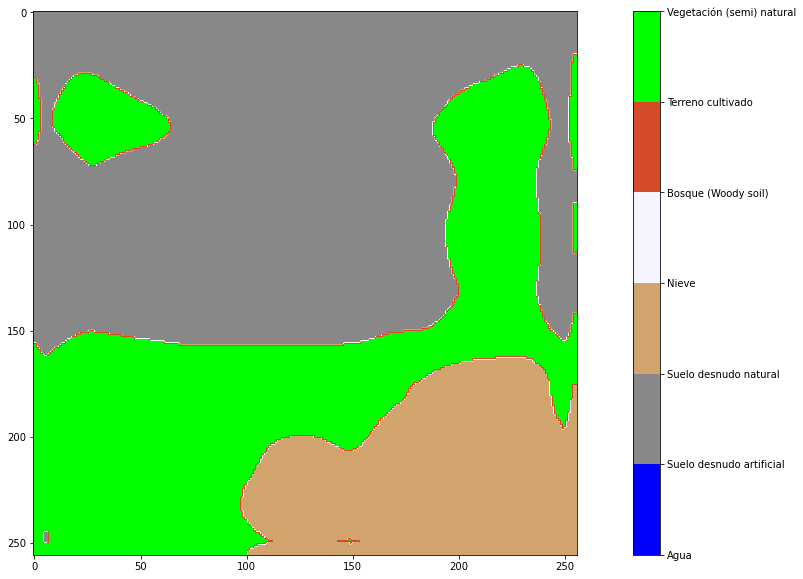

In [38]:
fig, ax = plt.subplots()
img = ax.imshow(mask[0], cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax)
cbar.set_ticks(boundaries)
cbar.set_ticklabels(meaning)
cbar.config_axis
plt.show()

A continuación vamos a cargar la imagen satelital y mostrarla en una configuración TCI

In [39]:
# Cargar todas las bandas de la imagen
imagen_pred_bands = load_source_img(example_folder_path)

Dimensiones de la imagen cargada

In [40]:
imagen_pred_bands.shape

(12, 256, 256)

Cargar en un arreglo las tres bandas RGB

In [41]:
ex_image_rgb = np.array([
    imagen_pred_bands[4],
    imagen_pred_bands[3],
    imagen_pred_bands[2]
])

Dimensión RGB

In [42]:
ex_image_rgb.shape

(3, 256, 256)

Visualizar el raster RGB

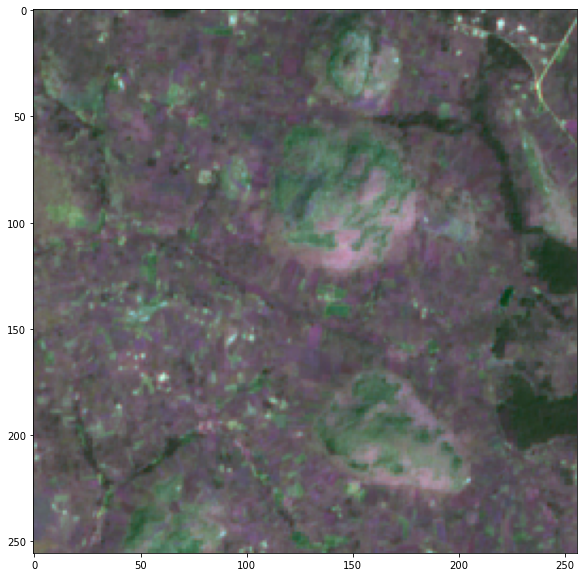

<AxesSubplot:>

In [43]:
rgb = ex_image_rgb
rgb_norm = rio_plot.adjust_band(rgb) # normalize bands to range between 1.0 to 0.0

rio_plot.show(rgb_norm)

Para culminar vamos a cargar la máscara real de la imagen

In [44]:
# Máscara
# Cargar la máscara inicial -> [clase, alto, ancho]
true_chip_id = np_data_folders[99][1]
true_mask_folder_path = get_label_mask_path_folder(chip_id=true_chip_id)
true_mask_raster = load_mask_img(true_mask_folder_path)

Dimensiones de la máscara real

In [45]:
true_mask_raster.shape

(256, 256)

Gráficar la máscara y mostrar la leyenda de las clases

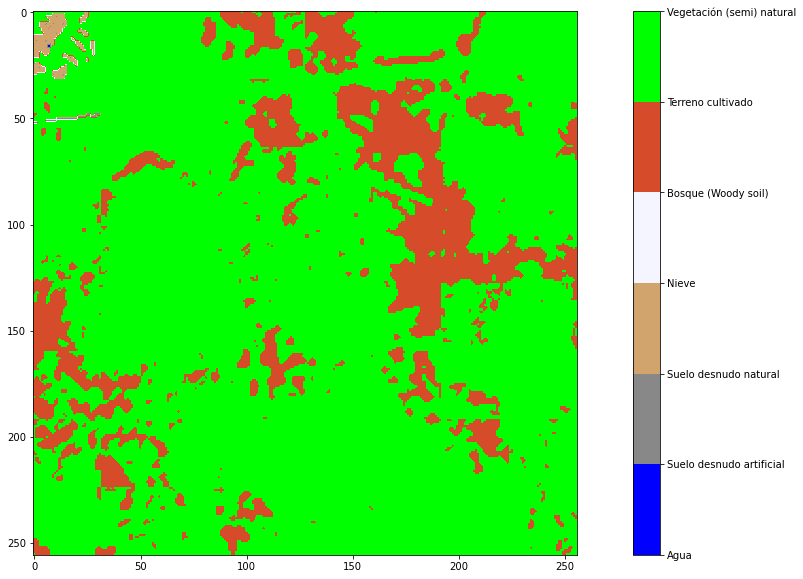

In [46]:
fig, ax = plt.subplots()
img = ax.imshow(true_mask_raster, cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax)
cbar.set_ticks(boundaries)
cbar.set_ticklabels(meaning)
cbar.config_axis
plt.show()